In [ ]:
using Pkg
Pkg.activate("../")

using NetCDF, PyPlot, PyCall, ColorSchemes, QuadGK
import Statistics: mean

PyPlot.matplotlib.rc("text", usetex=true)
PyPlot.matplotlib.rc("xtick", labelsize=8)
PyPlot.matplotlib.rc("ytick", labelsize=8)
PyPlot.matplotlib.rc("axes", labelsize=10)    # fontsize of the x and y labels
PyPlot.matplotlib.rc("font", family="sans-serif")
PyPlot.rc("text.latex", preamble="\\usepackage[T1]{fontenc} \\renewcommand*\\familydefault{\\sfdefault}  \\usepackage{sansmath}  \\sansmath")

mtick = pyimport("matplotlib.ticker");

In [2]:
layer1cases = [["layer1_tau1e-3_manyshortridges/"],
               ["layer1_tau5e-3_manyshortridgesCorrectTopo/"],
               ["layer1_tau2e-2_manyshortridgesCorrectTopo/"],
               ["layer1_tau5e-2_manyshortridges/"],
               ["layer1_tau1e-1_manyshortridges/"],
               ["layer1_tau2e-1_manyshortridges/"],
               ["layer1_tau3e-1_manyshortridges/"],
               ["layer1_tau5e-1_manyshortridges/"],
               ["layer1_tau1e-0_manyshortridgesCorrectTopo/"],
               ["layer1_tau1p5e-0_manyshortridgesCorrectTopo/"],
               ["layer1_tau2e-0_manyshortridgesCorrectTopo/"],
               ["layer1_tau2p5e-0_manyshortridgesCorrectTopo/"],
               ["layer1_tau3e-0_manyshortridgesCorrectTopo/"],
               ["layer1_tau5e-0_manyshortridgesCorrectTopo/"],
               ["layer1_tau6e-0_manyshortridgesCorrectTopo/"],
               ["layer1_tau7e-0_manyshortridgesCorrectTopo/"],
               ["layer1_tau8e-0_manyshortridgesCorrectTopo/"],
               ["layer1_tau1e1_manyshortridges/"],
               ["layer1_tau2e1_manyshortridges/"]
              ];


layer2cases = [["layer2_tau1e-3_manyshortridgesCorrectTopoStartFrom5e-3/"],
               ["layer2_tau2e-3_manyshortridgesCorrectTopo/"],
               ["layer2_tau5e-3_manyshortridgesCorrectTopo/"],
               ["layer2_tau2e-2_manyshortridgesCorrectTopo/"],
               ["layer2_tau5e-2_manyshortridgesCorrectTopo/"],
               ["layer2_tau1e-1_manyshortridgesCorrectTopo/"],
               ["layer2_tau2e-1_manyshortridgesCorrectTopo12hourlyOutput/"],
               ["layer2_tau3e-1_manyshortridgesCorrectTopo/"],
               ["layer2_tau5e-1_manyshortridgesCorrectTopo/"],
               ["layer2_tau6e-1_manyshortridgesCorrectTopo/"],
               ["layer2_tau7e-1_manyshortridgesCorrectTopo/"],
               ["layer2_tau1e-0_manyshortridgesCorrectTopo/"],
               ["layer2_tau2e-0_manyshortridgesCorrectTopo/"],
               ["layer2_tau3e-0_manyshortridgesCorrectTopo/"],
               ["layer2_tau4e-0_manyshortridgesCorrectTopo/"],
               ["layer2_tau5e-0_manyshortridgesCorrectTopo/"],
               ["layer2_tau6e-0_manyshortridgesCorrectTopo/"],
               ["layer2_tau8e-0_manyshortridgesCorrectTopo/"],
               ["layer2_tau1e1_manyshortridges/"],
               ["layer2_tau2e1_manyshortridgesCorrectTopo/"]               
              ];

layer3cases = [["layer3_tau1e-3_manyshortridges/"],
               ["layer3_tau5e-3_manyshortridges/"],
               ["layer3_tau2e-2_manyshortridges/"],
               ["layer3_tau1e-1_manyshortridges/"],
               ["layer3_tau5e-1_manyshortridges/"],
               ["layer3_tau1e-0_manyshortridges/"],
               ["layer3_tau2e-0_manyshortridges/"],
               ["layer3_tau5e-0_manyshortridges/"],
               ["layer3_tau6e-0_manyshortridges/"],
               ["layer3_tau8e-0_manyshortridges/"],
               ["layer3_tau1e1_manyshortridges/"]
              ];


layer4cases = [["layer4_tau1e-3_manyshortridges/"],
               ["layer4_tau5e-3_manyshortridges/"],
               ["layer4_tau2e-2_manyshortridges/"],
               ["layer4_tau1e-1_manyshortridges/"],
               ["layer4_tau2e-1_manyshortridges/"],
               ["layer4_tau5e-1_manyshortridges/"],
               ["layer4_tau1e-0_manyshortridges/"],
               ["layer4_tau5e-0_manyshortridges/"],
               ["layer4_tau8e-0_manyshortridges/"],
               ["layer4_tau1e1_manyshortridges/"]
              ];

In [3]:
xh, yh = ncread("../../data/layer1_tau1e-1_manyshortridges.nc", "xh"), ncread("../../data/layer1_tau1e-1_manyshortridges.nc", "yh")
nx, ny = length(xh), length(yh);
Lx, Ly = 3200, 1600

xmin, ymin = minimum(xh), minimum(yh)
x = [ xh[i]-xmin+2 for i=1:nx, j=1:ny]
y = [ yh[j]-ymin+2 for i=1:nx, j=1:ny];

dx, dy = 4e3, 4e3; # [km]

In [4]:
alllayercases = [layer1cases, layer2cases]
numlayers = [1, 2]

nseries = length(alllayercases)
WS = []
Transport = []

KE = []
MKE = []
EKE = []

APE = []
MAPE = []
EAPE = []


windstress = []
formstress = []
bottomdrag = []

for j = 1:length(alllayercases)
    layercases = alllayercases[j]
    nlayers = numlayers[j]
    ninterfaces = nlayers + 1
    
    WSj = []
    Transportj = zeros(nlayers, length(layercases))
    
    KEj = zeros(nlayers, length(layercases))
    MKEj = zeros(nlayers, length(layercases))
    EKEj = zeros(nlayers, length(layercases))

    APEj = zeros(ninterfaces, length(layercases))
    MAPEj = zeros(ninterfaces, length(layercases))
    EAPEj = zeros(ninterfaces, length(layercases))

    windstressj = []
    formstressj = []
    bottomdragj = []
    workj = []
    slopej = []
    for i = 1:length(layercases)
        datafile = "../../data/"*layercases[i][1][1:end-1]*".nc"
        ρ = ncread(datafile, "rho")
        push!(WSj, maximum(ncread(datafile, "tau")))
        Transportj[:, i] = ncread(datafile, "transportmean")
        KEj[:, i] = ρ .* dropdims(sum(ncread(datafile, "KE_time"), dims=(1, 2))*dx*dy, dims=(1, 2));
        MKEj[:, i] = ρ .* dropdims(sum(ncread(datafile, "MKE_time"), dims=(1, 2))*dx*dy, dims=(1, 2))
        EKEj[:, i] = ρ .* dropdims(sum(ncread(datafile, "EKE_time"), dims=(1, 2))*dx*dy, dims=(1, 2))

        APEj[:, i] = dropdims(sum(ncread(datafile, "APE_time"), dims=(1, 2))*dx*dy, dims=(1, 2));
        MAPEj[:, i] = dropdims(sum(ncread(datafile, "MAPE_time"), dims=(1, 2))*dx*dy, dims=(1, 2))
        EAPEj[:, i] = dropdims(sum(ncread(datafile, "EAPE_time"), dims=(1, 2))*dx*dy, dims=(1, 2))

        push!(windstressj, dropdims(sum(ncread(datafile, "windstress"), dims=(1, 2))*dx*dy, dims=(1, 2))[1])
        push!(formstressj, dropdims(sum(ncread(datafile, "formstress"), dims=(1, 2))*dx*dy, dims=(1, 2))[1])
        push!(bottomdragj, dropdims(sum(ncread(datafile, "bottomdrag"), dims=(1, 2))*dx*dy, dims=(1, 2))[1])
        tau = ncread(datafile, "tau")
        umean = ncread(datafile, "umean")

    end
    push!(WS, WSj)
    push!(Transport, Transportj)
    push!(KE, KEj)
    push!(MKE, MKEj)
    push!(EKE, EKEj)
    push!(APE, APEj)
    push!(MAPE, MAPEj)
    push!(EAPE, EAPEj)
    push!(windstress, windstressj)
    push!(formstress, formstressj)
    push!(bottomdrag, bottomdragj)
end

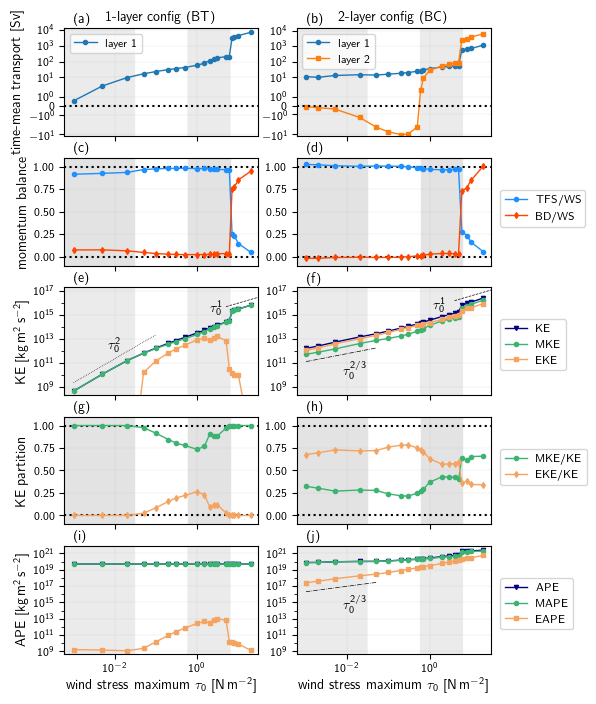

In [5]:
xmin, xmax = 6e-4, 3e1; # wind stress limits for plotting

fig, axs = subplots(5, 2, sharex = true, figsize=(5.5, 8.125))

for j=1:2
    if j==1
        sca(axs[1])
    elseif j==2
        sca(axs[1, 2])
    end
    for i=1:j
        if i==1
            loglog(WS[j], Transport[j][i, :], "o-", markersize=3, linewidth=1, label="layer "*string(i))
        else
            loglog(WS[j], Transport[j][i, :], "s-", markersize=3, linewidth=1, label="layer "*string(i))
        end
    end
    yscale("symlog")
    semilogx([xmin, xmax], [0, 0], ":k")
    xlim(xmin, xmax)
    legend(fontsize=8)
    grid(which="major", linewidth=0.1)        
end


for j=1:2
    sca(axs[2, j])
    semilogx([xmin, xmax], [0, 0], ":k")
    semilogx([xmin, xmax], [1, 1], ":k")
    semilogx(WS[j], formstress[j] ./ windstress[j], "o-", markersize=3, linewidth=1, label="TFS/WS", color="dodgerblue")
    semilogx(WS[j], bottomdrag[j] ./ windstress[j], "d-", markersize=3, linewidth=1, label="BD/WS", color="orangered")
    xlim(xmin, xmax)
    ylim(-0.1, 1.1)
    yticks(range(0, stop=1, step=0.25))
    grid(which="major", linewidth=0.1)    
end



for j=1:2
    sca(axs[3, j]) 
    loglog(WS[j], dropdims(sum(KE[j], dims=1), dims=1), "v-", markersize=3, linewidth=1, label="KE", color="navy")
    loglog(WS[j], dropdims(sum(MKE[j], dims=1), dims=1), "o-", markersize=3, linewidth=1, label="MKE", color="mediumseagreen")
    loglog(WS[j], dropdims(sum(EKE[j], dims=1), dims=1), "s-", markersize=3, linewidth=1, label="EKE", color="sandybrown")
    
    if j==1
        loglog(WS[j][1:5], 5*dropdims(sum(KE[j], dims=1), dims=1)[1]*(WS[j][1:5]/WS[j][1]).^2, ":k", linewidth=0.5)
    else
        loglog(WS[j][1:5], 0.08*dropdims(sum(KE[j], dims=1), dims=1)[1]*(WS[j][1:5]/WS[j][1]).^(2/3), "-.k", linewidth=0.5)
    end
    n = length(WS[j])
    tauline = [WS[j][n-5], 2*WS[j][n]]
    factor = 3*dropdims(sum(KE[j], dims=1), dims=1)[n]
    loglog(tauline, factor*(tauline/(WS[j][n])).^(1), "--k", linewidth=0.5)
    xlim(xmin, xmax)
    yscale("symlog")
    grid(which="major", linewidth=0.1)
    yticks(10 .^ range(9, stop=17, step=2))
    ylim(2e8, 2e17)

    sca(axs[4, j])        
    semilogx([xmin, xmax], [0, 0], ":k")
    semilogx([xmin, xmax], [1, 1], ":k")
    semilogx(WS[j], dropdims(sum(MKE[j], dims=1), dims=1) ./ dropdims(sum(KE[j], dims=1), dims=1), "o-", markersize=3, linewidth=1, label="MKE/KE", color="mediumseagreen")
    semilogx(WS[j], dropdims(sum(EKE[j], dims=1), dims=1) ./ dropdims(sum(KE[j], dims=1), dims=1), "d-", markersize=3, linewidth=1, label="EKE/KE", color="sandybrown")
    xlim(xmin, xmax)
    ylim(-0.1, 1.1)
    yticks(range(0, stop=1, step=0.25))
    grid(which="major", linewidth=0.1)

    sca(axs[5, j])        
    loglog(WS[j], dropdims(sum(APE[j], dims=1), dims=1), "v-", markersize=3, linewidth=1, label="APE", color="navy")
    loglog(WS[j], dropdims(sum(MAPE[j], dims=1), dims=1), "o-", markersize=3, linewidth=1, label="MAPE", color="mediumseagreen")
    loglog(WS[j], dropdims(sum(EAPE[j], dims=1), dims=1), "s-", markersize=3, linewidth=1, label="EAPE", color="sandybrown")
    if j==2
        loglog(WS[j][1:5], 0.08*dropdims(sum(EAPE[j], dims=1), dims=1)[1]*(WS[j][1:5]/WS[j][1]).^(2/3), "-.k", linewidth=0.5)
    end
    xlim(xmin, xmax)
    yscale("symlog")
    grid(which="major", linewidth=0.1)
    yticks((10 .^ range(1, stop=15, step=2))*1e8)
    ylim(5e8, 8e21)

end


sca(axs[1, 1])
title("1-layer config (BT)", fontsize=10)
ylabel(L"time-mean transport [$\mathrm{Sv}$]")
ylim(-1.3e1, 1.3e4)

sca(axs[1, 2])
title("2-layer config (BC)", fontsize=10)
ylim(-1.4e1, 1.4e4)

sca(axs[2, 1])
ylabel("momentum balance")

sca(axs[3, 1])
ylabel(L"KE [$\mathrm{kg}\,\mathrm{m}^2\,\mathrm{s}^{-2}$]")

sca(axs[4, 1])
ylabel("KE partition")

sca(axs[5, 1])
ylabel(L"APE [$\mathrm{kg}\,\mathrm{m}^2\,\mathrm{s}^{-2}$]")

sca(axs[5, 1])
xlabel(L"wind stress maximum $\tau_0$ [N$\,$m$^{-2}$]")
sca(axs[5, 2])
xlabel(L"wind stress maximum $\tau_0$ [N$\,$m$^{-2}$]")

for j=2:5
    sca(axs[j, 2])
    legend(fontsize=8, bbox_to_anchor=[1.05, 0.7], loc=2, borderaxespad=0)
end


axs[1, 1].annotate("(a)", xy=(0.05, 1.06), xycoords="axes fraction")
axs[1, 2].annotate("(b)", xy=(0.05, 1.06), xycoords="axes fraction")
axs[2, 1].annotate("(c)", xy=(0.05, 1.06), xycoords="axes fraction")
axs[2, 2].annotate("(d)", xy=(0.05, 1.06), xycoords="axes fraction")
axs[3, 1].annotate("(e)", xy=(0.05, 1.06), xycoords="axes fraction")
axs[3, 1].annotate(L"$\tau_0^2$", xy=(7e-3, 9e11))
axs[3, 1].annotate(L"$\tau_0^1$", xy=(2, 1e15))
axs[3, 2].annotate("(f)", xy=(0.05, 1.05), xycoords="axes fraction")
axs[3, 2].annotate(L"$\tau_0^1$", xy=(1.2, 2e15))
axs[3, 2].annotate(L"$\tau_0^{2/3}$", xy=(8e-3, 5e9))
axs[4, 1].annotate("(g)", xy=(0.05, 1.06), xycoords="axes fraction")
axs[4, 2].annotate("(h)", xy=(0.05, 1.06), xycoords="axes fraction");
axs[5, 1].annotate("(i)", xy=(0.05, 1.06), xycoords="axes fraction")
axs[5, 2].annotate("(j)", xy=(0.05, 1.06), xycoords="axes fraction");
axs[5, 2].annotate(L"$\tau_0^{2/3}$", xy=(8e-3, 5e13))


for i=[1, 3, 5], j=1:2
    sca(axs[i, j])
    xf = [1e-4, 3e-2, 3e-2, 1e-4]
    yf = [-1e25, -1.2e25, 1.1e25, 1e25]
    fill(xf, yf, color=(0.92, 0.92, 0.92))
    xf = [6e-1, 6.2, 6.2, 6e-1]
    yf = [-1.1e25, -1e25, 1e25, 1.1e25]
    fill(xf, yf, color=(0.92, 0.92, 0.92))
    xlim(xmin, xmax)
end

for i=[2, 4], j=1:2
    sca(axs[i, j])
    xf = [1e-4, 3e-2, 3e-2, 1e-4]
    yf = [-2, -2, 2, 2]
    fill(xf, yf, color=(0.89, 0.89, 0.89))
    xf = [6e-1, 6.2, 6.2, 6e-1]
    yf = [-2, -2, 2, 2]
    fill(xf, yf, color=(0.89, 0.89, 0.89))
    xlim(xmin, xmax)
end

savefig("transp_mombal_KE_APE.pdf", bbox_inches="tight");